In [1]:
import numpy as np
from random import random, uniform, randint
from matplotlib import pyplot as plt
import pandas as pd


from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [2]:
def get_angles(points):
    # вычисление углов полигона
    cnt = points
    num_points = len(cnt)
    angles = []
    for i, point in enumerate(cnt):
        point1 = cnt[i - 1]
        point2 = cnt[i]
        point3 = cnt[(i + 1) % num_points]
        angles.append(int(Vector(point2, point1).angle(Vector(point2, point3))* 180 / np.pi))

    return np.array(angles)

In [3]:
def S_from_triangle(triangle):
    # по точкам треугольника получить площадь
    x1 = triangle[0][0]
    y1 = triangle[0][1]
    x2 = triangle[1][0]
    y2 = triangle[1][1]    
    x3 = triangle[2][0]
    y3 = triangle[2][1]
    return 0.5*abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

right_triangle = [Point(0, 0, 0), Point(1, 0, 0), Point(0.5, 3**0.5/2, 0)]

def is_point_in_triangle(point, polygon=right_triangle):
    #проверка находится ли точка внутри треугольника
    #проверяем равенство площадей
    S = S_from_triangle(polygon)
    pA = polygon[0]
    pB = polygon[1]
    pC = polygon[2]
    S1 = S_from_triangle([pA, pB, point])
    S2 = S_from_triangle([pA, pC, point])
    S3 = S_from_triangle([pC, pB, point])
    if abs(S-S1-S2-S3) < 0.0001:
        return True
    else:
        return False
    
# def intersections_to_polygon(intersections, figure=CubeHalf()):
#     #не уверена что оно нужно
#     '''
#     функция из точек пересечения сечения с многогранником(в случайном порядке) возвращает 
#     последовательный обход вершин многоугольника
#     '''
#     #если нет пересечений
#     if len(intersections) == 0:
#         return []
    
    
#     point = intersections[0]
#     polygon = []
#     polygon.append(point)
#     del intersections[0]
    
#     while intersections:
#         for i, p in enumerate(intersections):
#             flag = False
#             for plane in figure.iterable_facets:
#                 #проверяем находятся ли две точки в одной плоскости
#                 if (p in plane) and (point in plane):
#                     polygon.append(p)
#                     del intersections[i]
#                     point = p
#                     flag = True
#                     break
#             if flag:
#                 break
#     return polygon

In [4]:
def make_random_plane(n=1):
    #сгенерировать одну случайную плоскость внутри куба
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(uniform(0, np.pi))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = Vector(center, Point(xm, ym, m1))
    
    if k2 >= 0:
        xn = 0
        yn = n
    else:
        xn = n
        yn = 0
        k2 = -k2
    m2 = n/2-2**(0.5)/2*n*k2
    v2 = Vector(center, Point(xn, yn, m2))
    
    #m1 и m2 - потенциальные минимумы
    
    if m1 <= m2:
        x = xm
        y = ym
        m = m1
    else:
        x = xn
        y = yn
        m = m2
    
    #генерируем "сдвиг"
    z = uniform(2*m - n, n)
    #возвращаем плоскость по точке и двум векторам
    return Plane(Point(x, y, z), v1, v2)


#не надо
def make_random_plane_3_into_sphere_1(r=1.8, center=Point(0.5, 0.5, 0.5)):
    #генерируем плоскость по вектору нормали и свигу вдоль этой нормали
    # r - радиус сдвига (шара который замощают)
    # center - координаты центра
    fi = uniform(0, 2*np.pi)
    teta = uniform(0, 2*np.pi) #пока так
    n = Vector(r*np.sin(teta)*np.cos(fi), 
               r*np.sin(teta)*np.sin(fi),
               r*np.cos(teta))
    alpha = uniform(-1, 1)
    point = Point(alpha*n[0]+center[0], alpha*n[1]+center[1], alpha*n[2]+center[2])
    return Plane(point, n)


def make_random_plane_3_into_sphere_arcsin(r=1.8, center=Point(0.5, 0.5, 0.5)):
    #генерируем плоскость по вектору нормали и свигу вдоль этой нормали
    # r - радиус сдвига (шара который замощают)
    # center - координаты центра
    fi = uniform(0, 2*np.pi)
    teta = np.arcsin(uniform(-1, 1)) #пока так
    n = Vector(r*np.sin(teta)*np.cos(fi), 
               r*np.sin(teta)*np.sin(fi),
               r*np.cos(teta))
    alpha = uniform(-1, 1)
    point = Point(alpha*n[0]+center[0], alpha*n[1]+center[1], alpha*n[2]+center[2])
    return Plane(point, n)

In [5]:
def generate_random_plane_angles(polyhedron):
    # генерируется плоскость внутри куба и проверяется пересекает ли она данный многогранник, возврается список углов
    # мы генерируем плоскость внутри куба стороной 1, так как всегда простые фигуры, описанные далее лежат внутри такого куба
    plane = make_random_plane_3_into_sphere_arcsin()
    # отбираем только те плоскости у которых непустое пересечение с многогранником
    points_intersection = polyhedron.intersection_with_plane(plane)
    if len(points_intersection) != 0:
        return get_angles(points_intersection)
    else:
        return []
    
def generates_n_plates(polyhedron, n=1000):
    # генерируем n плоскостей и получем распределение углов
    angles = [0]*181
    
    for i in range(n):
        angs = generate_random_plane_angles(polyhedron=polyhedron)
        if len(angs) != 0:
            for ang in angs:
                angles[ang] += 1
    
    return list(np.array(angles)/np.sum(angles))

def generate_vertex_distribution(polyhedron, n=1000):
    # генерирует n плоскостей и получаем распределение количеств вершин у многоугольников
    vertex = [0]*7
    for i in range(n):
        angs = generate_random_plane_angles(polyhedron)
        vertex[len(angs)] += 1
    
    return vertex

def make_table_vertex_distribution(polyhedron, n=1000, n_try=10):
    # красивый вывод распределений количеств вершин со статистическими величинами 
    vertex_distrs = []
    for i in range(n_try):
        vertex_distrs.append(generate_vertex_distribution(n=n, polyhedron=polyhedron))

    vertex_distrs = np.array(vertex_distrs)
    vertex_distrs[:, 0] = 0
    vertex_distrs = vertex_distrs/np.sum(vertex_distrs, axis=1)[:,None]*100
    mean = np.mean(vertex_distrs, axis=0)
    std = np.std(vertex_distrs, axis=0)
    var = np.var(vertex_distrs, axis=0)
    
    indexes = list(range(1, n_try+1)) + ['mean', 'std', 'dispersion']
    return pd.DataFrame(np.vstack((vertex_distrs, mean, std, var)), index=indexes)

In [13]:
#поскольку для моделей wcco предусмотрены различные параметры призмы, то для них в функции можно передавать параметры r,k,и _wcco

def generate_random_plane_angles_wcco_into_sphere_arcsin(wcco, r, k):
    # генерируется плоскость внутри куба и проверяется пересекает ли она данную модель WCCo, возврается список углов
    a, b, w, t = from_rk_to_abwt(r, k)
    plane = make_random_plane_3_into_sphere_arcsin(r=1.8*max(1, t))
    points_intersection = wcco.intersection_with_plane(plane)
    if len(points_intersection) != 0:
        return get_angles(points_intersection)
    else:
        return []
    
def generates_n_plates_wcco(wcco, r, k, n=1000):
    # генерируем n плоскостей и получем распределение углов
    angles = [0]*181
    for i in range(n):
        angs = generate_random_plane_angles_wcco_into_sphere_arcsin(wcco, r, k)
        if len(angs) != 0:
            for ang in angs:
                angles[ang] += 1
    
    return list(np.array(angles)/np.sum(angles))

def generate_vertex_distribution_wcco(wcco, r, k, n=1000):
    # генерирует n плоскостей и получаем распределение количеств вершин у многоугольников
    vertex = [0]*10
    for i in range(n):
        angs = generate_random_plane_angles_wcco_into_sphere_arcsin(wcco, r, k)
        vertex[len(angs)] += 1
    return vertex

def make_table_vertex_distribution_wcco(wcco, r, k, n=1000, n_try=10):
    # красивый вывод распределений количеств вершин со статистическими величинами 
    vertex_distrs = []
    for i in range(n_try):
        vertex_distrs.append(generate_vertex_distribution_wcco(wcco=wcco, r=r, k=k, n=n))

    vertex_distrs = np.array(vertex_distrs)
    vertex_distrs[:, 0] = 0
    vertex_distrs = vertex_distrs/np.sum(vertex_distrs, axis=1)[:,None]*100
    mean = np.mean(vertex_distrs, axis=0)
    std = np.std(vertex_distrs, axis=0)
    var = np.var(vertex_distrs, axis=0)
    
    indexes = list(range(1, n_try+1)) + ['mean', 'std', 'dispersion']
    return pd.DataFrame(np.vstack((vertex_distrs, mean, std, var)), index=indexes)

In [7]:
class Cube():
    #куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self, side=1, center=Point(0.5, 0.5, 0.5)):
        
        
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(a, a, 0) + vec
        self.D = Point(0, a, 0) + vec
        self.E = Point(0, 0, a) + vec
        self.F = Point(a, 0, a) + vec
        self.G = Point(a, a, a) + vec
        self.H = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F, self.G, self.H]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AD = Line(self.A, self.D)
        self.DC = Line(self.D, self.C)
        
        self.AE = Line(self.A, self.E)
        self.BF = Line(self.B, self.F)
        self.CG = Line(self.C, self.G)
        self.DH = Line(self.D, self.H)
        
        self.EF = Line(self.E, self.F)
        self.EH = Line(self.E, self.H)
        self.FG = Line(self.F, self.G)
        self.HG = Line(self.H, self.G)
        
        self.iterable_edges = [self.AB, self.BC, self.AD, self.DC, self.AE, self.BF,
                               self.CG, self.DH, self.EF, self.EH, self.FG, self.HG]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                # <3 Python's comparison operator
                self.A.x <= point.x <= self.G.x and
                self.A.y <= point.y <= self.G.y and
                self.A.z <= point.z <= self.G.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
        if intersections:
            polygon = [intersections.pop()]
            while intersections:
                last = polygon[-1]
                distances = [distance(last, x) for x in intersections]
                # We're only interested in the index of the next point,
                # this min function returns the minimum (index, distance)
                # tuple...
                successor = min(enumerate(distances), key=lambda x: x[1])
                # ...but we only need the index :)
                successor = successor[0]
                polygon.append(intersections.pop(successor))

            return polygon
        else:
            return []


In [8]:
class CubeHalf():
    #половина куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self):
        
        side=1
        center=Point(0.5, 0.5, 0.5)
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(0, a, 0) + vec
        self.D = Point(0, 0, a) + vec
        self.E = Point(a, 0, a) + vec
        self.F = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AC = Line(self.A, self.C)
        
        self.AD = Line(self.A, self.D)
        self.BE = Line(self.B, self.E)
        self.CF = Line(self.C, self.F)
        
        self.DE = Line(self.D, self.E)
        self.DF = Line(self.D, self.F)
        self.FE = Line(self.F, self.E)
        
        self.ABD = Plane(self.A, self.B, self.E)
        self.ACD = Plane(self.A, self.C, self.D)
        self.CBE = Plane(self.C, self.B, self.E)
        
        self.ABC = Plane(self.A, self.B, self.C)
        self.DEF = Plane(self.D, self.E, self.F)
        

        
        self.iterable_edges = [self.AB, self.BC, self.AC, self.AD, self.BE, self.CF,
                               self.DE, self.DF, self.FE]
        
        self.iterable_facets = [self.ABD, self.ACD, self.CBE, self.ABC, self.DEF]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                self.A.x <= point.x <= self.B.x and
                self.A.y <= point.y <= self.C.y and
                point.y <= point.x + 1 and
                self.A.z <= point.z <= self.D.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
#         if intersections:
#             point = intersections[0]
#             polygon = []
#             polygon.append(point)
#             del intersections[0]

#             while intersections:
#                 for i, p in enumerate(intersections):
#                     flag = False
#                     for plane in self.iterable_facets:
#                         if (p in plane) and (point in plane):
#                             polygon.append(p)
#                             del intersections[i]
#                             point = p
#                             flag = True
#                             break
#                     if flag:
#                         break
#             return polygon
#         else:
#             return []
        
        if intersections:
            #print(intersections)
            point = intersections[0]
            polygon = []
            polygon.append(point)
            del intersections[0]
            
            uu_kostyl = 0 

            while intersections:
                for i, p in enumerate(intersections):
                    uu_kostyl += 1
                    flag = False
                    for plane in self.iterable_facets:
                        if (p in plane) and (point in plane):
                            polygon.append(p)
                            del intersections[i]
                            point = p
                            flag = True
                            break
                    if flag:
                        break
                if uu_kostyl > 10000:
                    print('i had a problem with precision')
                    return []
            return polygon
        else:
            return []
        
#         if intersections:
#             polygon = [intersections.pop()]
#             while intersections:
#                 last = polygon[-1]
#                 distances = [distance(last, x) for x in intersections]
#                 # We're only interested in the index of the next point,
#                 # this min function returns the minimum (index, distance)
#                 # tuple...
#                 successor = min(enumerate(distances), key=lambda x: x[1])
#                 # ...but we only need the index :)
#                 successor = successor[0]
#                 polygon.append(intersections.pop(successor))

#             return polygon
#         else:
#             return []

In [9]:
class RegularTriangularPrism():
    #Правильная треугольная призма, 
    def __init__(self):
        
        side=1
        #)
        center=Point(0.5, 0.5, 0.5)
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(0.5*a, 3**0.5/2*a, 0) + vec
        self.D = Point(0, 0, a) + vec
        self.E = Point(a, 0, a) + vec
        self.F = Point(0.5*a, 3**0.5/2*a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AC = Line(self.A, self.C)
        
        self.AD = Line(self.A, self.D)
        self.BE = Line(self.B, self.E)
        self.CF = Line(self.C, self.F)
        
        self.DE = Line(self.D, self.E)
        self.DF = Line(self.D, self.F)
        self.FE = Line(self.F, self.E)
        
        self.ABD = Plane(self.A, self.B, self.E)
        self.ACD = Plane(self.A, self.C, self.D)
        self.CBE = Plane(self.C, self.B, self.E)
        
        self.ABC = Plane(self.A, self.B, self.C)
        self.DEF = Plane(self.D, self.E, self.F)
        

        
        self.iterable_edges = [self.AB, self.BC, self.AC, self.AD, self.BE, self.CF,
                               self.DE, self.DF, self.FE]
        
        self.iterable_facets = [self.ABD, self.ACD, self.CBE, self.ABC, self.DEF]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            right_triangle = [self.A, self.B, self.C]
            # intersect is actually (num, point)
            return (
                is_point_in_triangle(point=point, polygon=right_triangle)
                and self.A.z <= point.z <= self.D.z
            )
        
        intersections = list(filter(in_bounds, intersections))
        #print('problem not here')
        
        if intersections:
            #print(intersections)
            point = intersections[0]
            polygon = []
            polygon.append(point)
            del intersections[0]
            
            uu_kostyl = 0 

            while intersections:
                for i, p in enumerate(intersections):
                    uu_kostyl += 1
                    flag = False
                    for plane in self.iterable_facets:
                        if (p in plane) and (point in plane):
                            polygon.append(p)
                            del intersections[i]
                            point = p
                            flag = True
                            break
                    if flag:
                        break
                if uu_kostyl > 10000:
                    print('i had a problem with precision')
                    return []
            return polygon
        else:
            return []

In [10]:
def from_rk_to_abwt(r, k):
    b = 1/(2*r+1)
    a = r*b
    w = 3**0.5/2*(1-a)
    t = k*w
    return a, b, w, t

class WCCoPrism():
    #Модель зерна карбида вольфрама, 
    def __init__(self, r, k):
        
        self.a, self.b, self.w, self.t = from_rk_to_abwt(r, k)
        
        
        self.A = Point(self.a, 0, 0)
        self.B = Point(self.a+self.b, 0, 0)
        self.C = Point(1.5*self.a+self.b, 3**0.5/2*self.a, 0)
        self.D = Point(0.5+self.a/2, self.w, 0)
        self.E = Point(0.5-self.a/2, self.w, 0)
        self.F = Point(0.5*self.a, 3**0.5/2*self.a, 0)
        
        self.G = Point(self.a, 0, self.t)
        self.H = Point(self.a+self.b, 0, self.t)
        self.I = Point(1.5*self.a+self.b, 3**0.5/2*self.a, self.t)
        self.J = Point(0.5+self.a/2, self.w, self.t)
        self.K = Point(0.5-self.a/2, self.w, self.t)
        self.L = Point(0.5*self.a, 3**0.5/2*self.a, self.t)
        
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F,
                               self.G, self.H, self.I, self.J, self.K, self.L]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.CD = Line(self.C, self.D)
        self.DE = Line(self.D, self.E)
        self.EF = Line(self.E, self.F)
        self.FA = Line(self.F, self.A)
        
        self.AG = Line(self.A, self.G)
        self.BH = Line(self.B, self.H)
        self.CI = Line(self.C, self.I) 
        self.DJ = Line(self.D, self.J)
        self.EK = Line(self.E, self.K)
        self.FL = Line(self.F, self.L) 
        
        self.GH = Line(self.G, self.H)
        self.HI = Line(self.H, self.I)
        self.IJ = Line(self.I, self.J)
        self.JK = Line(self.J, self.K)
        self.KL = Line(self.K, self.L)
        self.LG = Line(self.L, self.G)
        
        self.ABC = Plane(self.A, self.B, self.C)
        self.GHI = Plane(self.G, self.H, self.I)
        
        self.ABH = Plane(self.A, self.B, self.H)
        self.BCH = Plane(self.B, self.C, self.H)
        self.CDJ = Plane(self.C, self.D, self.J)
        self.DEK = Plane(self.D, self.E, self.K)
        self.EFL = Plane(self.E, self.F, self.L)
        self.FAG = Plane(self.F, self.A, self.G)
        

        
        self.iterable_edges = [self.AB, self.BC, self.CD, self.DE, self.EF, self.FA,
                               self.AG, self.BH, self.CI, self.DJ, self.EK, self.FL, 
                               self.GH, self.HI, self.IJ, self.JK, self.KL, self.LG]
        
        self.iterable_facets = [self.ABC, self.GHI, self.ABH, self.BCH, 
                                self.CDJ, self.DEK, self.EFL, self.FAG]
        
    def is_point_in_truncated_triangle(self, point):
        polygon = [self.A, self.B, self.C, self.D, self.E, self.F, self.G]
        #проверяем равенство площадей
        S = 3**0.5/4-3*3**0.5/4*self.a**2
        pA = polygon[0]
        pB = polygon[1]
        pC = polygon[2]
        pD = polygon[3]
        pE = polygon[4]
        pF = polygon[5]
        S1 = S_from_triangle([pA, pB, point])
        S2 = S_from_triangle([pB, pC, point])
        S3 = S_from_triangle([pC, pD, point])
        S4 = S_from_triangle([pD, pE, point])
        S5 = S_from_triangle([pE, pF, point])
        S6 = S_from_triangle([pF, pA, point])
        if abs(S-S1-S2-S3-S4-S5-S6) < 0.000001:
            return True
        else:
            return False
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            #right_triangle = [self.A, self.B, self.C]
            # intersect is actually (num, point)
            return (
                self.is_point_in_truncated_triangle(point=point)
                and 0 <= point.z <= self.t
            )
        
        intersections = list(filter(in_bounds, intersections))
        #print('problem not here')
        
        if intersections:
            #print(intersections)
            point = intersections[0]
            polygon = []
            polygon.append(point)
            del intersections[0]
            
            uu_kostyl = 0 

            while intersections:
                for i, p in enumerate(intersections):
                    uu_kostyl += 1
                    flag = False
                    for plane in self.iterable_facets:
                        if (p in plane) and (point in plane):
                            polygon.append(p)
                            del intersections[i]
                            point = p
                            flag = True
                            break
                    if flag:
                        break
                if uu_kostyl > 1000:
                    print('i had a problem with precision')
                    return []
            #print(polygon)
            return polygon
        else:
            #print('[]')
            return []

i got a problem with arccos Vector(-9.979625919565027e-05, 0.0, 0.00012830675073105535) Vector(-9.979625919565027e-05, 0.0, 0.00012830675073105535)
i got a problem with arccos Vector(9.979625919565027e-05, 0.0, -0.00012830675073105535) Vector(9.979625919565027e-05, 0.0, -0.00012830675073105535)


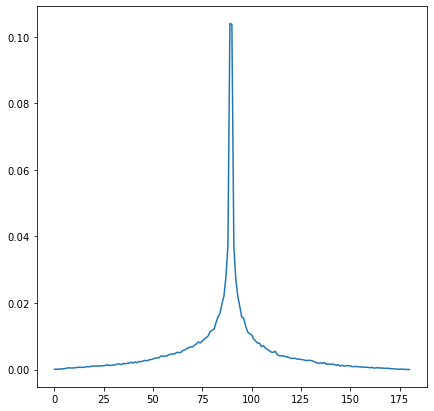

In [13]:
plt.figure(figsize=(7,7))
plt.plot(generates_n_plates(polyhedron=Cube(), n=100000))
plt.show()

i got a problem with arccos Vector(0.8654371769473139, -0.8654371769473139, 0.596060368806428) Vector(0.8654371769473139, -0.8654371769473139, 0.596060368806428)
i got a problem with arccos Vector(-0.8654371769473139, 0.8654371769473139, -0.596060368806428) Vector(-0.8654371769473139, 0.8654371769473139, -0.596060368806428)
i had a problem with precision


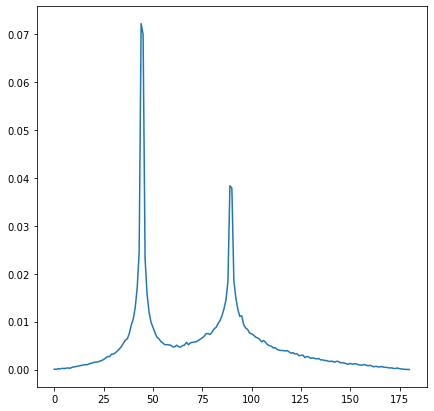

In [15]:
plt.figure(figsize=(7,7))
plt.plot(generates_n_plates(polyhedron=CubeHalf(), n=100000))
plt.show()

i had a problem with precision
i got a problem with arccos Vector(5.279309208083838e-05, 6.106360687951895e-05, 0.0) Vector(5.279309208083838e-05, 6.106360687951895e-05, 0.0)
i got a problem with arccos Vector(-5.279309208083838e-05, -6.106360687951895e-05, 0.0) Vector(-5.279309208083838e-05, -6.106360687951895e-05, 0.0)
i got a problem with arccos Vector(4.176528406607538e-05, 7.233959399499668e-05, -3.5555294552347405e-05) Vector(4.176528406607538e-05, 7.233959399499668e-05, -3.5555294552347405e-05)
i got a problem with arccos Vector(-4.176528406607538e-05, -7.233959399499668e-05, 3.5555294552347405e-05) Vector(-4.176528406607538e-05, -7.233959399499668e-05, 3.5555294552347405e-05)
i got a problem with arccos Vector(0.3731465399098111, 0.0, -0.9998143250922986) Vector(-6.929681603677981e-05, 0.0, 0.00018567490770138306)
i had a problem with precision


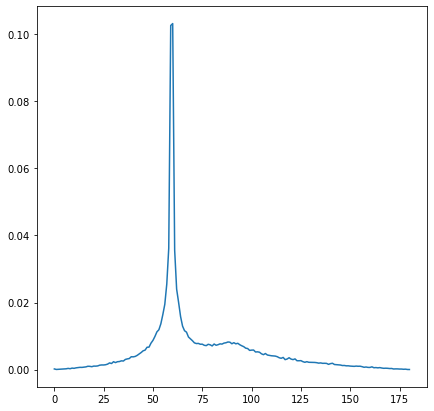

In [16]:
plt.figure(figsize=(7,7))
plt.plot(generates_n_plates(polyhedron=RegularTriangularPrism(), n=100000))
plt.show()

In [12]:
from_rk_to_abwt(0.6, 0.9)

(0.2727272727272727,
 0.45454545454545453,
 0.6298366572977735,
 0.5668529915679962)

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a 

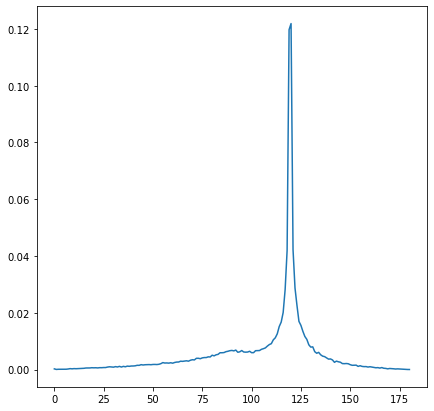

In [23]:
plt.figure(figsize=(7,7))
plt.plot(generates_n_plates_wcco(wcco=WCCoPrism(r=0.6, k=0.9), r=0.6, k=0.9, n=100000))
plt.show()

In [16]:
import utils

In [11]:
%%time
make_table_vertex_distribution(Cube(), n=100000, n_try=10)

i got a problem with arccos Vector(0.34665166064952124, 0.0, 0.2314286074710749) Vector(0.34665166064952124, 0.0, 0.2314286074710749)
i got a problem with arccos Vector(-0.34665166064952124, 0.0, -0.2314286074710749) Vector(-0.34665166064952124, 0.0, -0.2314286074710749)
i got a problem with arccos Vector(0.0, 0.26959740017174827, -0.4500485501222647) Vector(0.0, 0.26959740017174827, -0.4500485501222647)
i got a problem with arccos Vector(0.0, -0.26959740017174827, 0.4500485501222647) Vector(0.0, -0.26959740017174827, 0.4500485501222647)
i got a problem with arccos Vector(0.001969646035298589, 0.0, -3.397583581044028e-05) Vector(0.001969646035298589, 0.0, -3.397583581044028e-05)
i got a problem with arccos Vector(-0.001969646035298589, 0.0, 3.397583581044028e-05) Vector(-0.001969646035298589, 0.0, 3.397583581044028e-05)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arc

,0,1,2,3,4,5,6
1,0.0,0.000000,0.007625,23.881052,55.231923,17.412632,3.466768
2,0.0,0.002514,0.000000,23.819818,55.243577,17.334473,3.599618
3,0.0,0.000000,0.005064,24.285389,54.720612,17.446895,3.542041
4,0.0,0.002533,0.002533,24.276812,55.228228,17.113329,3.376564
5,0.0,0.000000,0.000000,24.501845,54.846673,17.205751,3.445731
6,0.0,0.002545,0.005089,23.944630,55.461971,17.125118,3.460648
7,0.0,0.000000,0.005061,24.421165,54.783775,17.168957,3.621043
8,0.0,0.000000,0.000000,24.221121,55.108234,16.887518,3.783128
9,0.0,0.000000,0.007623,24.602993,54.793302,17.074472,3.521610
10,0.0,0.000000,0.002549,24.120001,54.859430,17.503122,3.514898


In [14]:
%%time
make_table_vertex_distribution(CubeHalf(), n=100000, n_try=10)

i got a problem with arccos Vector(0.0, 5.025858766161129e-06, -1.535210696013145e-05) Vector(0.0, 5.025858766161129e-06, -1.535210696013145e-05)
i got a problem with arccos Vector(0.0, -5.025858766161129e-06, 1.535210696013145e-05) Vector(0.0, -5.025858766161129e-06, 1.535210696013145e-05)
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, -0.00023314017285258615, 4.99177256118033e-05) Vector(0.0, -0.00023314017285258615, 4.99177256118033e-05)
i got a problem with arccos Vector(0.0, 0.00023314017285258615, -4.99177256118033e-05) Vector(0.0, 0.00023314017285258615, -4.99177256118033e-05)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i go

,0,1,2,3,4,5,6
1,0.0,0.000000,0.008135,64.045340,31.388128,4.558397,0.0
2,0.0,0.005438,0.002719,63.484338,31.974657,4.532848,0.0
3,0.0,0.002710,0.005421,63.815255,31.549846,4.626769,0.0
4,0.0,0.005419,0.008129,63.635625,31.720270,4.630558,0.0
5,0.0,0.002712,0.002712,63.702940,31.759249,4.532386,0.0
6,0.0,0.000000,0.002713,64.129550,31.307980,4.559757,0.0
7,0.0,0.000000,0.002696,64.175362,31.127828,4.694114,0.0
8,0.0,0.000000,0.010798,63.831223,31.541722,4.616257,0.0
9,0.0,0.000000,0.002709,64.170978,31.099493,4.726820,0.0
10,0.0,0.000000,0.008087,64.095099,31.112189,4.784625,0.0


In [16]:
%%time
make_table_vertex_distribution(RegularTriangularPrism(), n=100000, n_try=10)

i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(-0.2643807306481333, 0.0, 1.0) Vector(-2.311655244913169e-05, 0.0, 8.74366009674259e-05)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.5, -0.8660254037844386, -0.997051524881284) Vector(-4.6130584310133393e-05, 7.990051580797353e-05, 9.198913886010462e-05)
i got a problem with arccos Vector(-2.0598375739144803e-05, -3.567743333354745e-05, 0.00012678307917046716) Vector(-2.0598375739144803e-05, -3.567743333354745e-05, 0.00012678307917046716)
i got a problem with arccos Vector(2.0598375739144803e-05, 3.567743333354745e-05, -0.00012678307917046716) Vector(2.0598375739144803e-05, 3.567743333354745e-05, -0.000126783079170

,0,1,2,3,4,5,6
1,0.0,0.005700,0.000000,65.908573,30.608755,3.476972,0.000000e+00
2,0.0,0.011334,0.011334,65.954493,30.421354,3.601485,0.000000e+00
3,0.0,0.005669,0.002835,65.178445,31.298013,3.512203,2.834708e-03
4,0.0,0.002856,0.002856,65.427902,30.852948,3.713437,0.000000e+00
5,0.0,0.017176,0.002863,65.796404,30.610901,3.572655,0.000000e+00
6,0.0,0.014264,0.008558,65.284989,31.037827,3.654362,0.000000e+00
7,0.0,0.002836,0.005672,65.476461,30.930233,3.584799,0.000000e+00
8,0.0,0.002819,0.002819,66.021087,30.401443,3.571831,0.000000e+00
9,0.0,0.008532,0.017064,66.495080,29.878846,3.600478,0.000000e+00
10,0.0,0.008576,0.008576,65.285004,30.961637,3.736207,0.000000e+00


In [17]:
%%time
make_table_vertex_distribution_wcco(wcco=WCCoPrism(r=0.6, k=0.9), r=0.6, k=0.9, n=100000, n_try=10)

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(-4.66496432832697e-06, 0.0, -2.4682378102491853e-06) Vector(-4.66496432832697e-06, 0.0, -2.4682378102491853e-06)
i got a problem with arccos Vector(4.66496432832697e-06, 0.0, 2.4682378102491853e-06) Vector(4.66496432832697e-06, 0.0, 2.4682378102491853e

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(5.0389468764455714e-05, 0.0, 8.507913578537085e-06) Vector(5.0389468764455714e-05, 0.0, 8.507913578537085e-06)
i got a problem with arccos Vector(-5.0389468764455714e-05, 0.0, -8.507913578537085e-06) Vector(-5.0389468764455714e-05, 0.0, -8.507913578537085e-06)
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with p

,0,1,2,3,4,5,6,7,8,9
1,0.0,0.000000,0.018157,10.676350,21.511575,19.114843,41.634135,6.568316,0.476623,0.0
2,0.0,0.000000,0.000000,10.862821,22.058361,19.171800,41.284115,6.150803,0.472101,0.0
3,0.0,0.000000,0.004571,10.948071,21.439020,19.217407,41.492960,6.381423,0.516548,0.0
4,0.0,0.000000,0.009161,10.896849,21.601319,18.953829,41.306339,6.627886,0.604617,0.0
5,0.0,0.000000,0.022750,10.656111,21.512422,19.323869,41.914642,6.010556,0.559651,0.0
6,0.0,0.000000,0.017924,10.991621,21.786082,19.402249,41.116638,6.291168,0.394318,0.0
7,0.0,0.000000,0.013472,10.849650,22.076522,19.215915,40.955631,6.471169,0.417640,0.0
8,0.0,0.000000,0.009052,10.735461,21.692691,18.949989,41.448291,6.702874,0.461643,0.0
9,0.0,0.000000,0.018397,11.116221,20.995263,19.569517,41.314446,6.498643,0.487513,0.0
10,0.0,0.004560,0.009119,10.906438,21.589458,19.405435,41.336859,6.296735,0.451395,0.0
